# Проверка гипотез в бизнесе
В этом проекте вы попробуете себя в роли аналитика крупного сервиса проката самокатов GoFast. Сервис проката самокатов предоставил три датасета с данными о пользователях сервиса, их поездках за один год, а также стоимости услуг в подписках.

**Задача** - проанализировать демографию пользователей и особенности использования самокатов, а также определить возможную выгоду от распространения платной подписки на самокаты.

---
## 1. Загрузка данных

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

In [5]:
df_users_go = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
df_rides_go = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
df_subscriptions_go = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

In [6]:
display(df_users_go.head())
display(df_rides_go.head())
display(df_subscriptions_go.head())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


По смотрим на количество строк в каждом датафрейме

In [8]:
print(df_users_go.shape[0], df_rides_go.shape[0], df_subscriptions_go.shape[0])

1565 18068 2


---
## 2. Знакомство с данными и их предварительная подготовка

Определеним типы данных

In [11]:
df_rides_go.dtypes

user_id       int64
distance    float64
duration    float64
date         object
dtype: object

Приведем столбец `date` в датафрейме `df_rides_go` к типу даты pandas, используя метод `pd.to_datetime()`

In [13]:
df_rides_go['date'] = pd.to_datetime(df_rides_go['date'])

На основе столбца date создадим новый столбец month, содержащий номер месяца. Это нужно для последующей группировки данных и анализа сезонных трендов.

In [15]:
df_rides_go['month'] = df_rides_go['date'].dt.month

В датафрейме пользователей df_users_go определим количество пропусков и дубликатов. Это необходимо для понимания полноты и уникальности данных пользователей.

In [17]:
print(df_users_go.isna().sum().sum(), df_users_go.duplicated().sum())

0 31


При наличии пропущенных значений заполним их нулями, а все дубликаты удалим. Это шаг необходим для улучшения качества данных, что является ключевым для точного анализа. 

In [19]:
df_users_go = df_users_go.drop_duplicates()

В датафрейме поездок df_rides_go округлим время поездки duration до целого числа стандартным методом round(). Затем приведем эту колонку к целочисленному типу int. Этот шаг затем поможет нам правильно рассчитать прибыль, так как плата взимается только за целое число минут.

In [21]:
df_rides_go['duration'] = df_rides_go['duration'].round(decimals = 0)

In [22]:
df_rides_go['duration'] = df_rides_go['duration'].astype('int')

## 3. Исследовательский анализ данных (EDA)

Пользуясь данными из датафрейма df_users_go, изучим количество пользователей в каждом из городов. 

In [25]:
users_by_city_count = df_users_go['city'].value_counts().sort_values(ascending = False)

In [26]:
display(users_by_city_count)

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

Создадим и выведем на экран серию subscription_type_count с количеством пользователей для каждого типа подписки subscription_type.

In [28]:
subscription_type_count = df_users_go['subscription_type'].value_counts().sort_values(ascending = False)

In [29]:
display(subscription_type_count)

subscription_type
free     835
ultra    699
Name: count, dtype: int64

Построим круговую диаграмму, указав процент пользователей с free и ultra подпиской. 

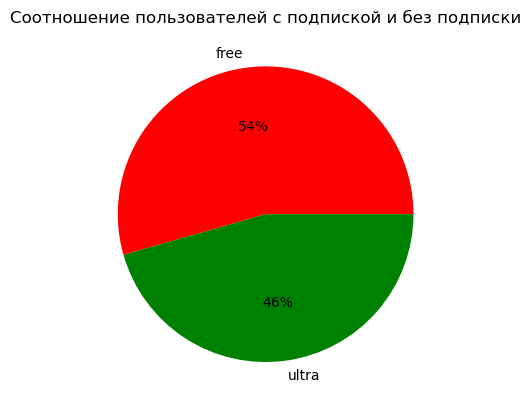

In [31]:
subscription_type_count.plot(
    kind='pie', 
    title='Соотношение пользователей с подпиской и без подписки',
    autopct='%.0f%%',  
    ylabel='',  
    colors=['red', 'green']  
)
plt.show()

Построим гистограмму возрастов age пользователей самокатов.

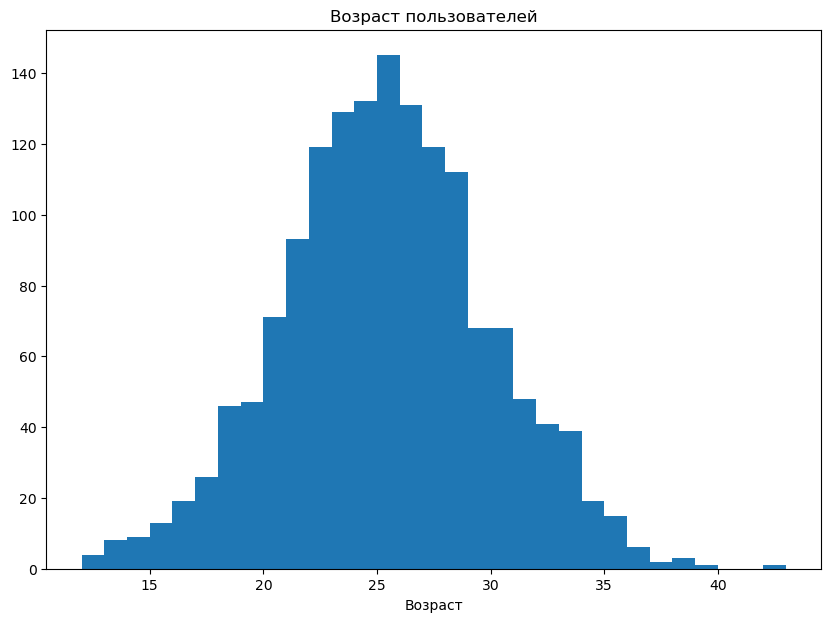

In [33]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(10, 7))
n_bins = max(df_users_go['age']) - min(df_users_go['age'])
# Строим гистограмму с помощью pandas через plot(kind='hist')
df_users_go['age'].hist(bins = n_bins)
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.grid()
plt.show()

Рассчитаем долю несовершеннолетних (возрастом менее 18 лет) пользователей самокатов.

In [35]:
minor_users_count = df_users_go[df_users_go['age'] < 18].shape[0]
total_users_count = df_users_go['age'].shape[0]
users_under_18_ratio = round((minor_users_count / total_users_count) * 100)
print(f'Доля несовершеннолетних пользователей самокатов составляет {users_under_18_ratio}%.')

Доля несовершеннолетних пользователей самокатов составляет 5%.


Длительность поездки является важной метрикой в работе сервиса проката самокатов. Если средняя длительность поездок будет слишком высокой, самокаты будут быстрее выходить из строя. Если слишком низкой, значит, клиентам что-то не нравится в сервисе.

In [37]:
duration_mean = round(df_rides_go['duration'].mean())
duration_std = round(df_rides_go['duration'].std())

duration_pct25 = round(df_rides_go['duration'].quantile(0.25))
duration_pct75 = round(df_rides_go['duration'].quantile(0.75))

print(f'Средняя длительность поездки {duration_mean} минут со стандартным отклонением {duration_std}. Основная часть поездок занимает от {duration_pct25} до {duration_pct75} минут.')

Средняя длительность поездки 18 минут со стандартным отклонением 6. Основная часть поездок занимает от 14 до 22 минут.


---
## Задание 4. Объединение данных

Объединим датафреймы с информацией о пользователях `df_users_go` и поездках `df_rides_go`. 

In [40]:
df = df_users_go.merge(df_rides_go, on = 'user_id', how = 'left')

Присоединим к полученному датафрейму `df` информацию о подписках из `df_subscriptions_go`

In [42]:
df = df.merge(df_subscriptions_go, on = 'subscription_type', how = 'left')

In [43]:
display(df.head())

# Выводим количество строк и столбцов в объединённом датафрейме
n_rows = df.shape[0]
n_cols = df.shape[1]
print(f'В полученном датафрейме {n_rows} строк и {n_cols} столбцов.')

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26,2021-08-28,8,6,0,199


В полученном датафрейме 18068 строк и 12 столбцов.


Создадим два вспомогательных датафрейма на основе `df`: первый только для пользователей с подпиской `df_ultra` и второй только для пользователей без подписки `df_free`.

In [45]:
# Создание датафрейма для пользователей с подпиской
df_ultra = df[df['subscription_type'] == 'ultra']

# Создание датафрейма для пользователей без подписки
df_free = df[df['subscription_type'] == 'free']

На одном графике построим гистограмму распределения длительности поездок `duration` для пользователей с подпиской и без.

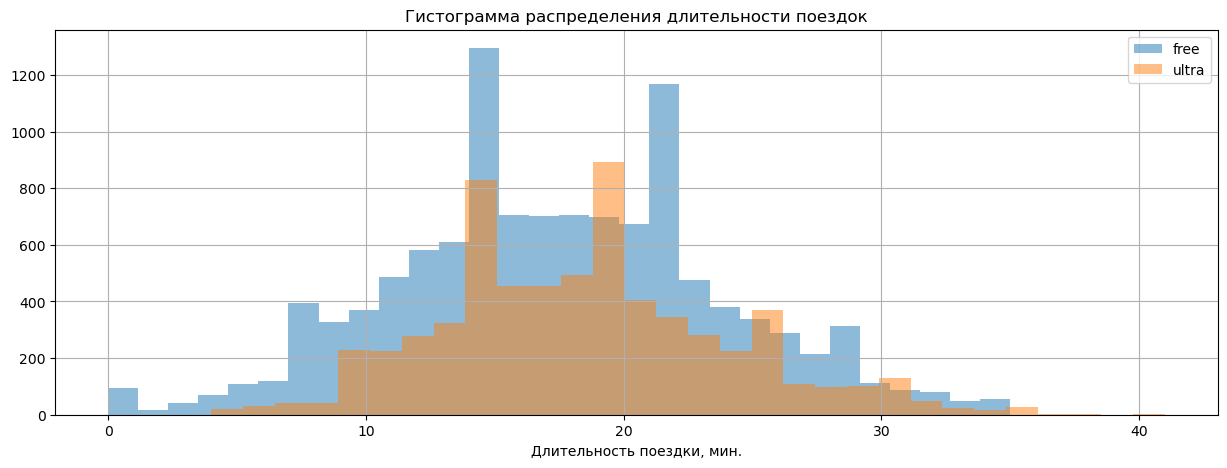

Средняя длительность поездки для пользователей без подписки 17 мин, а для пользователей с подпиской 19 мин


In [47]:
# Гистограмма длительности поездки для пользователей с подпиской и без
plt.figure(figsize=(15, 5))

# Строим гистограмму для пользователей без подписки
df_free['duration'].hist(bins=30, label='free', alpha=0.5)

# Строим гистограмму для пользователей с подпиской
df_ultra['duration'].hist(bins=30, label='ultra', alpha=0.5)

# Устанавливаем подпись оси X
plt.xlabel('Длительность поездки, мин.')

# Устанавливаем заголовок графика
plt.title('Гистограмма распределения длительности поездок')

# Добавляем легенду
plt.legend()

plt.show()

# Расчет и вывод на экран средней длительности поездки для пользователей с подпиской и без
mean_duration_free = round(df_free['duration'].mean())
mean_duration_ultra = round(df_ultra['duration'].mean())
print(f'Средняя длительность поездки для пользователей без подписки {mean_duration_free} мин, а для пользователей с подпиской {mean_duration_ultra} мин')

---
## 5. Подсчёт выручки

Сгруппируем данные по следующим столбцам: `user_id`, `name`, `subscription_type`, `month`.

In [50]:
df_gp = df.groupby(['user_id', 'name', 'subscription_type', 'month'], as_index=False)

Создадим новый датафрейм `df_agg`. В нём для каждой группы рассчитаем и добавим в датафрейм следующие агрегированные значения, используя метод `agg()`:
- `total_distance` — сумма значений в столбце `distance`.
- `total_duration` — сумма значений в столбце `duration`.
- `rides_count` — количество элементов в столбце `duration`.
- `subscription_type` — первое значение в группе для столбца `subscription_type`.
- `minute_price` — первое значение в группе для столбца `minute_price`.
- `start_ride_price` — первое значение в группе для столбца `start_ride_price`.
- `subscription_fee` — первое значение в группе для столбца `subscription_fee`.

In [52]:
df_agg = df_gp.agg(
    total_distance=('distance', 'sum'),
    total_duration=('duration', 'sum'),
    rides_count=('duration', 'count'),
    subscription_type=('subscription_type', 'first'),
    minute_price=('minute_price', 'first'),
    start_ride_price=('start_ride_price', 'first'),
    subscription_fee=('subscription_fee', 'first'),
)

Рассчитаем месячную выручку на пользователя

In [54]:
def calculate_monthly_revenue(row):
    monthly_revenue = (row['start_ride_price'] * row['rides_count'] + 
                       row['minute_price'] * row['total_duration'] + 
                       row['subscription_fee'])
    return monthly_revenue

In [55]:
df_agg['monthly_revenue'] = df_agg.apply(calculate_monthly_revenue, axis=1)

Найдем пользователя с максимальной суммарной выручкой за весь период наблюдения и для него выведем на экран `user_id`, имя, месяц, количество поездок и выручку за каждый из месяцев.

In [57]:
df_agg_all=df_agg.groupby('user_id').agg({'monthly_revenue':'sum'}).reset_index()
max_revenue=df_agg_all[df_agg_all['monthly_revenue']==df_agg_all['monthly_revenue'].max()]
max_revenue_us=max_revenue['user_id'].iloc[0]
display(df_agg[['user_id', 'name', 'month', 'rides_count', 'monthly_revenue']].loc[df_agg['user_id']==max_revenue_us])

,user_id,name,month,rides_count,monthly_revenue
8877,1236,Александр,1,2,228
8878,1236,Александр,2,3,614
8879,1236,Александр,3,5,762
8880,1236,Александр,4,1,202
8881,1236,Александр,5,3,574
8882,1236,Александр,6,1,282
8883,1236,Александр,7,1,290
8884,1236,Александр,8,2,452
8885,1236,Александр,9,1,122
8886,1236,Александр,10,3,430


---
## 6. Проверка гипотез

Напишем вспомогательную функцию `print_stattest_results(p_value, alpha)`, которая будет интерпретировать результаты статистического теста на основе p-value и заданного уровня значимости (α-уровня). Функция должна решать, следует ли принять альтернативную гипотезу или сохранить нулевую гипотезу.

У функции два параметра:
- `p_value` (тип `float`) — значение p-value, полученное в результате выполнения статистического теста.
- `alpha` (тип `float`, необязательный, по умолчанию `alpha = 0.05`) — уровень значимости статистического теста, который используется как порог для принятия решения об отклонении нулевой гипотезы.

In [60]:
def print_stattest_results(p_value:float, alpha:float = 0.05):
    if p_value<=alpha:
        print(f'Полученное значение p_value={p_value} меньше критического уровня alpha={alpha}. Принимаем альтернативную гипотезу.')
    else:
        print(f'Полученное значение p_value={p_value} больше критического уровня alpha={alpha}. Опровергнуть нулевую гипотезу нельзя.')
print_stattest_results(p_value=0.0001)
print_stattest_results(p_value=0.1)

Полученное значение p_value=0.0001 меньше критического уровня alpha=0.05. Принимаем альтернативную гипотезу.
Полученное значение p_value=0.1 больше критического уровня alpha=0.05. Опровергнуть нулевую гипотезу нельзя.


Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Сформулируем нулевую и альтернативную гипотезы:

Нулевая гипотеза (Н0): Среднее время поездки у пользователей с подпиской и без подписки одинаковое.

Альтернативная гипотеза (Н1): Среднее время поездки у пользователей с подпиской больше, чем у пользователей без подписки.

In [62]:
ultra_duration = df_ultra['duration']  # пользователи с подпиской Ultra
free_duration = df_free['duration']    # пользователи без подписки

results = st.ttest_ind(ultra_duration, free_duration, alternative='greater')
p_value = results.pvalue

print_stattest_results(p_value)

ultra_mean_duration = round(ultra_duration.mean(), 2)
free_mean_duration = round(free_duration.mean(), 2)

print(f'Средняя длительность поездки тарифа Ultra {ultra_mean_duration}')
print(f'Средняя длительность поездки тарифа Free {free_mean_duration}')

Полученное значение p_value=3.1600689435611813e-35 меньше критического уровня alpha=0.05. Принимаем альтернативную гипотезу.
Средняя длительность поездки тарифа Ultra 18.55
Средняя длительность поездки тарифа Free 17.39


Проанализируем ещё одну важную продуктовую гипотезу. Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, меньше 3130 метров?

Сформулируем нулевую и альтернативную гипотезы:

- Нулевая гипотеза (Н0): Средняя дистанция поездки у пользователей с подпиской равна 3130 м.

- Альтернативная гипотеза (Н1): Средняя дистанция поездки у пользователей с подпиской больше 3130 м.

In [64]:
null_hypothesis = 3130
ultra_distance = df_ultra['distance']

results = st.ttest_1samp(ultra_distance, null_hypothesis, alternative = 'greater')
p_value = results.pvalue
print_stattest_results(p_value)

Полученное значение p_value=0.9195368847849785 больше критического уровня alpha=0.05. Опровергнуть нулевую гипотезу нельзя.


Проверим гипотезу о том, что выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

Сформулируем нулевую и альтернативную гипотезы:

Нулевая гипотеза (Н0): Средняя месячная выручка у пользователей с подпиской и без подписки одинаковая.

Альтернативная гипотеза (Н1): Средняя месячная выручка у пользователей с подпиской выше, чем у пользователей без подписки.

In [66]:
revenue_ultra = df_agg[df_agg['subscription_type'] == 'ultra']['monthly_revenue']
revenue_free = df_agg[df_agg['subscription_type'] == 'free']['monthly_revenue']

results = st.ttest_ind(revenue_ultra, revenue_free, alternative='greater')
p_value = results.pvalue

print_stattest_results(p_value)

mean_revenue_ultra = round(revenue_ultra.mean())
mean_revenue_free = round(revenue_free.mean())

print(f'Средняя выручка подписчиков Ultra {mean_revenue_ultra} руб')
print(f'Средняя выручка подписчиков Free {mean_revenue_free} руб')

Полученное значение p_value=1.7274069878387966e-37 меньше критического уровня alpha=0.05. Принимаем альтернативную гипотезу.
Средняя выручка подписчиков Ultra 359 руб
Средняя выручка подписчиков Free 322 руб


---
## 7. Распределения

В компании возникла идея предлагать дополнительную скидку подписчикам, совершающим длительные поездки продолжительностью более 30 минут. Оценимдолю таких поездок.

Рассчитаем выборочное среднее и стандартное отклонение

In [109]:
# Вычисляем среднее значение
mu = df_ultra['duration'].mean()

# Вычисляем стандартное отклонение
sigma = df_ultra['duration'].std()

# Задаём целевое время
target_time = 30

# Делаем вывод
print(f'Средняя длительность поездки {round(mu, 1)}, стандартное отклонение {round(sigma)}.')

Средняя длительность поездки 18.5, стандартное отклонение 6.


вычислим значение функции распределения в точке, это позволит узнать вероятность того, что случайная величина примет значение меньше заданного либо равное ему.

In [112]:
# Вычисляем вероятность того, что случайная величина будет меньше указанного значения или равна ему
duration_norm_dist = st.norm(mu, sigma)  # Создаём нормальное распределение
prob = round(1 - duration_norm_dist.cdf(target_time), 3)  # Используем CDF для нахождения накопленной вероятности

print(f'Вероятность поездки более 30 минут {prob}')

Вероятность поездки более 30 минут 0.02


Проверим, какой процент пользователей совершает поездки в интервале от 20 до 30 минут. Возможно, именно для них стоит провести промоакцию?

In [115]:
# Определяем границы интервала
low = 20
high = 30

# Вычисляем вероятность попадания в интервал
prob_low = duration_norm_dist.cdf(low)
prob_high = duration_norm_dist.cdf(high)
prob_interval = round(prob_high - prob_low, 3)

# Выводим результат
print(f'Вероятность того, что пользователь совершит поездку длительностью от {low} до {high} минут: {prob_interval}')

Вероятность того, что пользователь совершит поездку длительностью от 20 до 30 минут: 0.377


Длительные поездки могут негативно сказываться на сроке службы самоката. В связи с этим принято решение установить критическую дистанцию, превышение которой будет сопровождаться дополнительной платой. Для этого необходимо определить расстояние, которое превышается только в 10% поездок (90-й процентиль).

Ссмоделируем распределение длительности поездок, предполагая, что оно подчиняется нормальному закону, и рассчитать критическую дистанцию, ниже которой находится 90% всех поездок.

In [118]:
mu = df['distance'].mean()
sigma = df['distance'].std()
target_prob = 0.90

distance_norm = st.norm(mu, sigma)
critical_distance = distance_norm.ppf(target_prob)

print(f'{100 * target_prob} % поездок имеют дистанцию ниже критического значения {critical_distance:.2f} М.')

90.0 % поездок имеют дистанцию ниже критического значения 4501.94 М.
